In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna 

In [2]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

In [4]:
df_gedi = pd.read_csv("DATA/df_union_gedi.csv").dropna()
df_gedi.columns

Index(['RFDI', 'DPDD', 'DpRVIVV', 'VH', 'VV', 'B11', 'B11_contrast',
       'B11_corr', 'B11_diss', 'B11_ent', 'B11_var', 'B12', 'B2', 'B3', 'B4',
       'B8', 'EVI', 'GCI', 'MSAVI', 'NDMI', 'NDVI', 'SAVI', 'Slope',
       'elevation', 'N_efectivo_estratos', 'lon', 'lat', 'DpRVIHH', 'HH', 'HV',
       'HV_contrast', 'HV_corr', 'HV_diss', 'HV_ent', 'HV_var'],
      dtype='object')

In [21]:
df_gedi.shape

(4259, 35)

In [51]:
variables_predictoras =['B11', "B12", "lat", "lon", "GCI", "B4", "elevation"] 

variable_objetivo =  'N_efectivo_estratos'
X = np.array(df_gedi[variables_predictoras] )
Y = np.array(df_gedi[variable_objetivo] )
# 2️⃣ Divide los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=593)

In [52]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [53]:
# Crear la "study" para realizar la optimización bayesiana
from optuna.samplers import TPESampler
sampler = TPESampler(seed=593)

study_rf1 = optuna.create_study(direction='minimize', sampler = sampler)  # Queremos minimizar el RMSE

[I 2025-05-20 01:14:29,852] A new study created in memory with name: no-name-3020870d-0188-47d5-bac6-f83157cf89e8


In [54]:
def kling_gupta_efficiency(y_obs, y_pred):
    # 1) correlación
    r    = np.corrcoef(y_obs, y_pred)[0,1]
    # 2) sesgo de medias
    beta = y_pred.mean() / y_obs.mean()
    # 3) razón de coeficientes de variación
    cv_obs  = y_obs.std(ddof=1)  / y_obs.mean()
    cv_pred = y_pred.std(ddof=1) / y_pred.mean()
    gamma = cv_pred / cv_obs
    
    # 4) fórmula KGE
    return 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)

In [55]:
# Número de iteraciones de la optimización
n_trials = 100  # Número de iteraciones a realizar
# Set seed for reproducibility
np.random.seed(593)
# K-Fold para la evaluación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=593)

# Inicia la optimización manual
for i in range(n_trials):
    # 1️⃣ Iniciar una nueva prueba
    trial = study_rf1.ask()
    
    # 2️⃣ Sugerir los hiperparámetros (Optuna los selecciona automáticamente)
    n_estimators = trial.suggest_int('n_estimators', 100, 800)  # Número de árboles
    max_depth = trial.suggest_int('max_depth', 3, 100)  # Profundidad máxima
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)  # División mínima de nodos
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 15)  # Hojas mínimas por nodo
    max_features = trial.suggest_int('max_features', 1,20)  # Máximo de características
    np.random.seed(593)
    # 3️⃣ Crear el modelo de RandomForestRegressor con los hiperparámetros generados
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=593,
        n_jobs=-1  # Usa todos los núcleos de la CPU
    )
    
   
     # Validación cruzada con escalado en cada fold
    rmse_scores = []
    r2_scores = []
    rrmse_scores = []
    mape_scores = []
    kge_scores = []

    for train_idx, val_idx in kf.split(X_train):
        # Dividir en entrenamiento y validación para este fold
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]

        # Escalar los datos del fold
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)

        # Entrenar y validar el modelo
        model.fit(X_train_fold, Y_train_fold)
        Y_val_pred = model.predict(X_val_fold)

        # Calcular métricas
        rmse = root_mean_squared_error(Y_val_fold, Y_val_pred)
        rrmse = rmse/Y_val_fold.mean()
        mape =  mean_absolute_percentage_error(Y_val_fold, Y_val_pred) * 100  # en %
        r2 = r2_score(Y_val_fold, Y_val_pred)
        kge = kling_gupta_efficiency(Y_val_fold, Y_val_pred)



        rmse_scores.append(rmse)
        rrmse_scores.append(rrmse)
        mape_scores.append(mape)
        r2_scores.append(r2)
        kge_scores.append(kge)
    
    # 5️⃣ Calcular la puntuación promedio
    mean_rmse = np.mean(rmse_scores)  # Se usa negativo porque scikit-learn devuelve la métrica negativa
    mean_rrmse = np.mean(rrmse_scores)
    mean_mape = np.mean(mape_scores)
    mean_r2 = np.mean(r2_scores)
    mean_kge = np.mean(kge_scores)

    # 6 calcular desviación estandar de la metrica}

    sd_rmse = np.std(rmse_scores)  # Se usa negativo porque scikit-learn devuelve la métrica negativa
    sd_rrmse = np.std(rrmse_scores)
    sd_mape = np.std(mape_scores)
    sd_r2 = np.std(r2_scores)
    sd_kge = np.std(kge_scores)

    # 7 calcular 

    # 7 almacena las metricas

    
    trial.set_user_attr('mean_r2', mean_r2)

    trial.set_user_attr('sd_r2', sd_r2)

    trial.set_user_attr('mean_rmse', mean_rmse)

    trial.set_user_attr('sd_rmse', sd_rmse)

    trial.set_user_attr('mean_rrmse', mean_rrmse)

    trial.set_user_attr('sd_rrmse', sd_rrmse)

    trial.set_user_attr('mean_mape', mean_mape)

    trial.set_user_attr('sd_mape', sd_mape)

    trial.set_user_attr('mean_kge', mean_kge)

    trial.set_user_attr('sd_kge', sd_kge)


    
    # 6️⃣ Registrar los resultados en la "study"
    study_rf1.tell(trial, mean_mape)
   
    
    # Imprimir los resultados de la iteración actual
    print(f"Iteración {i+1}/{n_trials}")
    print(f"Hiperparámetros: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, max_features={max_features}")
    print(f"RMSE = {mean_rmse}, R2 = {mean_r2},RRMSE = {mean_rrmse}, MAPE = {mean_mape} , KGE =  {mean_kge} ")
    print("="*50)

Iteración 1/100
Hiperparámetros: n_estimators=182, max_depth=77, min_samples_split=10, min_samples_leaf=15, max_features=5
RMSE = 1.060886337717418, R2 = 0.4546463537500832,RRMSE = 0.12194324453485246, MAPE = 10.801522036811674 , KGE =  0.5417515584947441 
Iteración 2/100
Hiperparámetros: n_estimators=433, max_depth=6, min_samples_split=12, min_samples_leaf=7, max_features=1
RMSE = 1.0756585307308544, R2 = 0.43943564890435083,RRMSE = 0.12364236040095719, MAPE = 11.13184013233343 , KGE =  0.49241771546298485 
Iteración 3/100
Hiperparámetros: n_estimators=559, max_depth=71, min_samples_split=3, min_samples_leaf=15, max_features=8
RMSE = 1.0612473472553596, R2 = 0.4543836113828098,RRMSE = 0.12198434202314652, MAPE = 10.777343528683947 , KGE =  0.545489777694654 
Iteración 4/100
Hiperparámetros: n_estimators=713, max_depth=7, min_samples_split=10, min_samples_leaf=2, max_features=2
RMSE = 1.0616902939571733, R2 = 0.4538612896423936,RRMSE = 0.1220360408790506, MAPE = 10.86840578741619 , KGE

KeyboardInterrupt: 

In [42]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study_rf1)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [10.839368724144544, 11.254369675534589, 10.779644943782797,
                    10.94281503810797, 10.677779856844243, 11.094273073798778,
                    10.70687117740467, 10.70600005225651, 10.8776563229475,
                    10.744838809720612, 10.669290209358916, 10.670080501808393,
                    10.710357192853316, 10.669291857234125, 10.662538689129232,
                    10.667123509166272, 10.678066086209622, 10.714400487908673,
                    10.751484974425587, 10.651953636455605, 10.670153882404232,
                    10.666728384659148, 10.663765523092685, 10.656961040637142,
                    10.647060663457207, 10.636666168781607, 10.63691371367197,
                    10.631539671820871, 10.633279775251863, 10.63312824013953,
                    10.62380040729072, 10.625409433779769, 10.625085081175426,
                    10.59039239341613, 10.599173536583148, 10.599863107570297,
                    10.596452765419325, 10.762916432749115, 10.689700415715235,
                    10.599915293176164, 10.637207930845154, 10.599168601022772,
                    10.597492150132869, 10.625298785906862, 10.596267014662256,
                    10.692775030657597, 10.716844785963058, 10.644899336865695,
                    10.583291978193023, 10.611217239192579, 10.660985489230757,
                    10.596759015560954, 10.596914336006131, 10.581981000149781,
                    11.074548617937145, 10.747963185652367, 10.624195318540329,
                    10.582729644195624, 10.581825769702508, 10.562015982630571,
                    10.589877083582227, 10.614563269541147, 10.565852666896614,
                    10.56103115728283, 10.566087346452885, 10.565852666896614,
                    10.57808210245627, 10.570478326392557, 10.570227137101678,
                    10.730425945065255, 10.626139289926378, 10.571963634368407,
                    10.819219728308209, 11.266512517750204, 10.588004485339974,
                    10.576706256779904, 10.66796977289936, 10.583027387842789,
                    10.595123231240217, 10.781011980323798, 10.624481824145965,
                    10.587038752361673, 10.582743299086598, 10.604325613473303,
                    10.598066983174471, 10.724638775661461, 10.593882336199396,
                    10.584845389215982, 10.658566828752276, 10.732660233378487,
                    10.935084055211888, 10.578082102456271, 10.575667984878127,
                    10.600979225799088, 10.761978072176667, 10.583318075149295,
                    10.5898664235348, 10.58159782523703, 10.668078232882483,
                    10.583429101442272]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [10.839368724144544, 10.839368724144

In [43]:
# 8️⃣ Imprimir los mejores hiperparámetros encontrados, la métrica objetivo y las métricas personalizadas
print("\n🔍 Mejores hiperparámetros encontrados:")
best_params = study_rf1.best_params
best_mae = study_rf1.best_value  # Esta es la mejor métrica (RMSE) obtenida
best_trial = study_rf1.best_trial  # El mejor trial, que tiene toda la información

# Imprimir los hiperparámetros y la métrica principal
print(f"Hiperparámetros: {best_params}")
print(f"Mejor puntuación (RMSE): {best_mae}")
# Imprimir las métricas registradas con set_user_attr
print("\n🔍 Métricas adicionales registradas en set_user_attr:")
for attr_name, attr_value in best_trial.user_attrs.items():
    print(f"{attr_name}: {attr_value}")


🔍 Mejores hiperparámetros encontrados:
Hiperparámetros: {'n_estimators': 569, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 12}
Mejor puntuación (RMSE): 10.56103115728283

🔍 Métricas adicionales registradas en set_user_attr:
mean_r2: 0.46678645685179576
sd_r2: 0.04113940152273654
mean_rmse: 1.0492274813359885
sd_rmse: 0.03860588683252442
mean_rrmse: 0.12060333125500353
sd_rrmse: 0.004578335127177071
mean_mape: 10.56103115728283
sd_mape: 0.4828364217849447
mean_kge: 0.5661042131125067
sd_kge: 0.04104617349101186


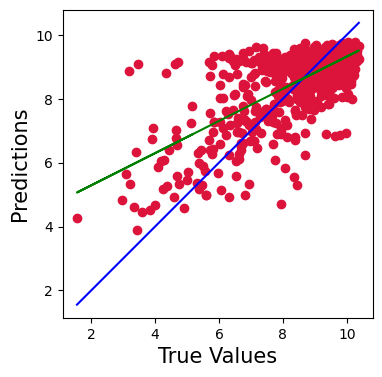

['B11', 'B12', 'lat', 'lon', 'GCI', 'B4', 'elevation', 'Slope', 'NDVI', 'B3']

In [44]:
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import linregress, pearsonr


# Entrenar el modelo final con los mejores hiperparámetros
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Crear el modelo con los mejores hiperparámetros
final_model_rf1 = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=593,
    n_jobs=-1
)


# Entrenar el modelo con el conjunto de entrenamiento
final_model_rf1.fit(X_train_scaled, Y_train)
importance = final_model_rf1.feature_importances_

# Predecir los valores para el conjunto de prueba
Y_pred = final_model_rf1.predict(X_test_scaled)

# Calcular los residuos

slope, intercept, r_value, p_value, std_err = linregress(Y_test, Y_pred)

# Gráfico de residuos
 # Graficar la regresión
plt.figure(figsize=(4,4))
plt.scatter(Y_test, Y_pred, c='crimson')

p1 = max(max(Y_pred), max(Y_test))
p2 = min(min(Y_pred), min(Y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.plot(Y_test, slope * Y_test + intercept, color='green', label='Línea de regresión')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()
variables_predictoras

In [45]:
final_model_rf1.feature_importances_

array([0.04525219, 0.38481915, 0.09807358, 0.08886487, 0.12490562,
       0.04377867, 0.06032283, 0.0599999 , 0.0453633 , 0.04861989])

In [46]:
name_modelo = "SAR - RF sin seleccion" 
rf1_pred = pd.DataFrame({"MODELO":name_modelo, "Y_test":Y_test, "Y_pred":Y_pred})

In [47]:
# Calcular R2 y RMSE


from sklearn.metrics import root_mean_squared_error, r2_score
modelo = "SAR - RF sin seleccion"

r2 = r2_score(Y_test, Y_pred)
rmse = root_mean_squared_error(Y_test, Y_pred)

mape =  mean_absolute_percentage_error(Y_test, Y_pred) * 100  # en %
r2 = r2_score(Y_test, Y_pred)
kge = kling_gupta_efficiency(Y_test, Y_pred)
print(
    f"╔══════════════════════════╗\n"
    f"║   Métricas del modelo    ║\n"
    f"╠══════════════════════════╣\n"
    f"║ R²   : {r2:8.3f}        ║\n"
    f"║ RMSE : {rmse:8.3f}        ║\n"
    f"║ MAPE : {mape:8.2f} %     ║\n"
    f"║ KGE  : {kge:8.3f}        ║\n"
    f"╚══════════════════════════╝"
)

╔══════════════════════════╗
║   Métricas del modelo    ║
╠══════════════════════════╣
║ R²   :    0.493        ║
║ RMSE :    1.061        ║
║ MAPE :    10.62 %     ║
║ KGE  :    0.591        ║
╚══════════════════════════╝


In [48]:
importance_df = pd.DataFrame({'Variable': variables_predictoras, 'Importancia': final_model_rf1.feature_importances_})

importance_svr1= importance_df.sort_values(by='Importancia', ascending=False)

importance_svr1

,Variable,Importancia
1,B12,0.384819
4,GCI,0.124906
2,lat,0.098074
3,lon,0.088865
6,elevation,0.060323
7,Slope,0.060000
9,B3,0.048620
8,NDVI,0.045363
0,B11,0.045252
5,B4,0.043779


In [49]:
importance_svr1["Importancia"].mean()

0.10000000000000002

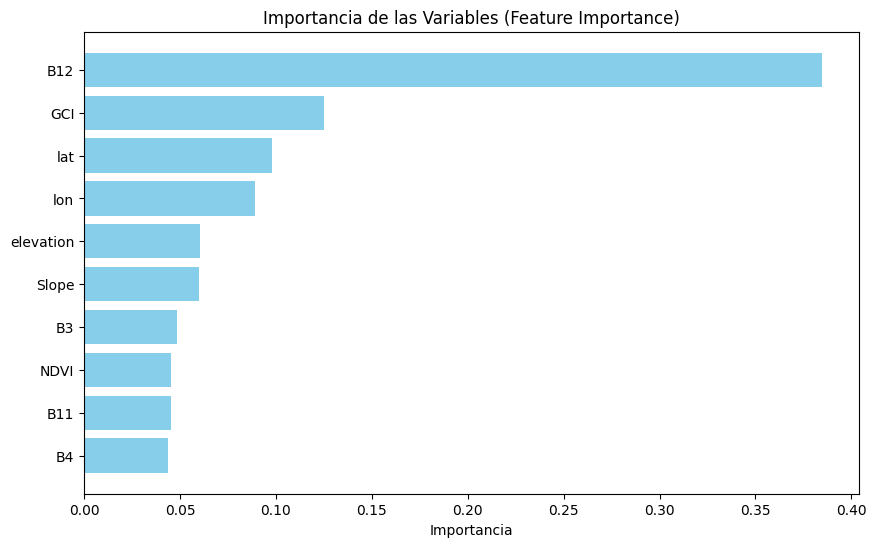

In [50]:

plt.figure(figsize=(10, 6))
plt.barh(importance_svr1['Variable'], importance_svr1['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de las Variables (Feature Importance)')
plt.gca().invert_yaxis()  # Para mostrar las variables más importantes en la parte superior
plt.show()